In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.2 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
# from tensorflow.keras.utils.np_utils import to_categorical
%matplotlib inline

In [8]:
data_train = pd.read_csv("/content/drive/MyDrive/longdoc_sentimentAnalysis/data_preprocessing/train_unmarked.csv",index_col=False)
data_test = pd.read_csv("/content/drive/MyDrive/longdoc_sentimentAnalysis/data_preprocessing/test_unmarked.csv",index_col=False)

<Axes: >

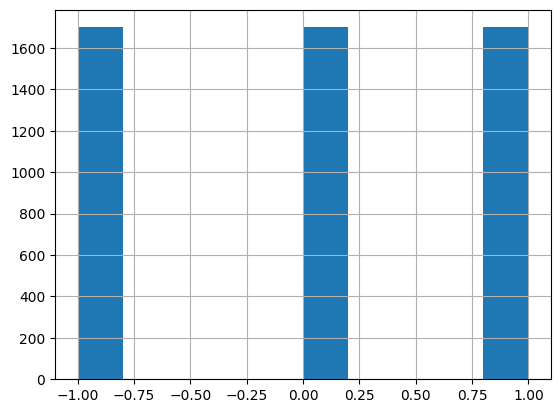

In [9]:
data_train['Class'].hist()

In [10]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, auc, roc_curve, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb

#use for LSTM and WordEmbedding Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional
from tensorflow.keras.layers import Embedding,SpatialDropout1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.initializers import Constant

**Metric**

In [11]:
def calculate_metrics(X_test_scaled, Y_test,model = None,naive = False):
    # Get model predictions
    if model:
       y_predict_r = model.predict(X_test_scaled)
    elif naive == True:
      _,y_predict_r = test_naive_bayes(X_test_scaled,Y_test,log_prior,log_likelihood)
    else:
       y_predict_r = X_test_scaled
    # Calculate evaluation metrics for assesing performance of the model.
    # roc=roc_auc_score(Y_test, y_predict_r)
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r, average='macro')
    rec = recall_score(Y_test, y_predict_r, average='macro')
    f1 = f1_score(Y_test, y_predict_r, average='macro')

    return acc, prec, rec, f1

def get_metrics(X_test, Y_test, model = None, naive = False):
    # All features of dataset are float values. You normalize all features of the train and test dataset here.

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    # Make predictions on test dataset and calculate metrics.

    acc, prec, rec, f1 = calculate_metrics(X_test, Y_test, model = model, naive = naive)

    display_df = pd.DataFrame([[acc, prec, rec, f1]], columns=["Accuracy", "Precision", "Recall", "F1 Score"])
    return display_df

In [12]:
X_train = data_train['text'].to_list()
X_test = data_test['text'].to_list()
y_train = data_train['Class'].to_list()
y_test = data_test['Class'].to_list()
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size=0.05,random_state=16)

#Method 1: naive bayes

In [13]:
import numpy as np

def count_tweets(tweets, ys):
    result = {}
    for y,tweet in zip(ys,tweets):
        lst_tweet = tweet.strip().split()
        for word in lst_tweet:
            tup = (word,y)
            if tup in result.keys():
               result[tup] += 1
            else:
               result[tup] = 1
    return result

def train_naive_bayes(freqs,train_x,train_y):
    loglikelihood = {}
    logprior = 0

    N_pos = 0
    N_neg = 0

    vocab = set([ele[0] for ele in freqs.keys()])

    for pair in freqs.keys():
        if pair[1] == 1:
           N_pos += freqs[pair]
        else:
           N_neg += freqs[pair]

    D = len(train_y) #number of sentences
    D_pos = np.sum(train_y == np.ones(len(train_y)))
    D_neg = D - D_pos

    V = len(vocab)
    log_prior = np.log(D_pos) - np.log(D_neg)
    log_likelihood = {}
    for word in vocab:
        freqs_pos = freqs.get((word,1),0)
        neg_pos = freqs.get((word,0),0)

        #smoothing
        freqs_pos_prob = (freqs_pos + 1)/(N_pos + V)
        freqs_neg_prob = (neg_pos + 1)/(N_neg + V)

        log_likelihood[word] = np.log(freqs_pos_prob) - np.log(freqs_neg_prob)

    return log_prior,log_likelihood

def naive_bayes_predict(tweet,log_prior,log_likelihood):
    tweet = tweet.strip().split()

    res = 0

    for word in tweet:
        if word in log_likelihood:
           res += log_likelihood[word]
    res += log_prior

    return res

def test_naive_bayes(test_x,test_y,log_prior,log_likelihood):
    y_hat = []
    for tweet in test_x:
        # print(tweet)
        res = naive_bayes_predict(tweet,log_prior,log_likelihood)
        if res >= 0.5:
           y_hat.append(1)
        elif res <= -0.5:
           y_hat.append(-1)
        else:
          y_hat.append(0)

    y_hat = np.array(y_hat)
    accuracy = np.sum(test_y == y_hat)/len(y_hat)
    return accuracy, y_hat

def predict(sentence,log_likelihood,log_prior):
    tweet = sentence.strip().split()

    res = 0

    for word in tweet:
        if word in log_likelihood:
           res += log_likelihood[word]

    res += log_prior
    if res >= 0:
       return "positive"
    return "negative"

In [14]:
freqs = count_tweets(X_train + X_val,y_train + y_val)
log_prior,log_likelihood = train_naive_bayes(freqs,X_train + X_val,y_train + y_val)

train_res,_ = test_naive_bayes(X_train + X_val,y_train + y_val,log_prior,log_likelihood)
test_res,y_hat = test_naive_bayes(X_test,y_test,log_prior,log_likelihood)

print('train_acc: ',train_res)
print('test_acc: ',test_res)

train_acc:  0.34098039215686277
test_acc:  0.33714285714285713


In [15]:
all_features_eval_df = get_metrics(X_test, y_test, naive=True)
all_features_eval_df.index = ['Naive Bayes']

# Creating an empty DataFrame
results = pd.DataFrame({})

# Using pd.concat instead of append
results = pd.concat([results, all_features_eval_df])

# Display the last 10 rows
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168


#Method 2: TF_IDF and Tokenizer method

In [16]:

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(train, test):
    tf = TfidfVectorizer(ngram_range=(1, 5))
    tf.fit(train)
    train = tf.transform(train)
    test = tf.transform(test)
    return train, test


def tokenization(train, test, vocab_size, max_len):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(train)

    train = tokenizer.texts_to_sequences(train)
    test = tokenizer.texts_to_sequences(test)
    padded_train = pad_sequences(train, maxlen=max_len, padding='post', truncating='post')
    padded_test = pad_sequences(test, maxlen=max_len, padding='post', truncating='post')

    return padded_train, padded_test

In [17]:
class SA():
    def __init__(self, mode, vocab_size=10000, max_len=420, split=False, test_size=0.20588235294):
        self.X_train, self.Y_train = X_train + X_val, y_train + y_val
        self.X_test, self.Y_test = X_test, y_test

        if mode == 'tfidf':
            self.X_train, self.X_test = tfidf(self.X_train, self.X_test)
        elif mode == 'tokenization':
            self.X_train, self.X_test = tokenization(self.X_train, self.X_test, vocab_size, max_len)

        if split == True:
            self.X_train, self.X_valid, self.Y_train, self.Y_valid = train_test_split(self.X_train, self.Y_train,
                                                                                    test_size=test_size, shuffle=True, random_state=42)

**Tokenization**

In [18]:
ds = SA(mode='tokenization')

In [19]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier().fit(ds.X_train, ds.Y_train)
# sgd_prediction = sgd.predict(ds.X_test)

all_features_eval_df = get_metrics(ds.X_test, ds.Y_test, sgd)
all_features_eval_df.index = ['Tokenization_SGD']

# Using pd.concat instead of append
results = pd.concat([results, all_features_eval_df])

# Display the last 10 rows
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479


In [20]:
from sklearn.svm import SVC
svc = SVC(C=1000).fit(ds.X_train, ds.Y_train)
# svc_prediction = svc.predict(ds.X_test)

all_features_eval_df = get_metrics(ds.X_test, ds.Y_test, svc)
all_features_eval_df.index = ['Tokenization_SVM']

# Using pd.concat instead of append
results = pd.concat([results, all_features_eval_df])

# Display the last 10 rows
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479
Tokenization_SVM,0.366667,0.371823,0.366667,0.364633


**TF-IDF**

In [21]:
ds = SA(mode='tfidf')

In [22]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier().fit(ds.X_train, ds.Y_train)
# sgd_prediction = sgd.predict(ds.X_test)
# print(classification_report(ds.Y_test, sgd_prediction))

all_features_eval_df = get_metrics(ds.X_test, ds.Y_test, sgd)
all_features_eval_df.index = ['TF-IDF sgd']

# Using pd.concat instead of append
results = pd.concat([results, all_features_eval_df])

# Display the last 10 rows
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479
Tokenization_SVM,0.366667,0.371823,0.366667,0.364633
TF-IDF sgd,0.709524,0.710426,0.709524,0.709571


In [23]:
from sklearn.svm import SVC
svc = SVC(C=1000).fit(ds.X_train, ds.Y_train)

all_features_eval_df = get_metrics(ds.X_test, ds.Y_test, svc)
all_features_eval_df.index = ['TF-IDF SVM']

# Using pd.concat instead of append
results = pd.concat([results, all_features_eval_df])

# Display the last 10 rows
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479
Tokenization_SVM,0.366667,0.371823,0.366667,0.364633
TF-IDF sgd,0.709524,0.710426,0.709524,0.709571
TF-IDF SVM,0.685714,0.698842,0.685714,0.686470


**TF-IDF better embedding than tokenization method => apply this embedding with deep learning method**

**Non-parametric model**

In [24]:
random_forestModel = RandomForestClassifier(n_estimators=400,
                                            max_depth=10,
                                            min_samples_split=400,
                                            random_state=12,
                                            max_features=None)
random_forestModel.fit(ds.X_train, ds.Y_train)

RandomForestClassifier(max_depth=10, max_features=None, min_samples_split=400,
                       n_estimators=400, random_state=12)

In [25]:
all_features_eval_df = get_metrics(ds.X_test , ds.Y_test, random_forestModel)
all_features_eval_df.index = ['RandomForest']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479
Tokenization_SVM,0.366667,0.371823,0.366667,0.364633
TF-IDF sgd,0.709524,0.710426,0.709524,0.709571
TF-IDF SVM,0.685714,0.698842,0.685714,0.686470
RandomForest,0.566667,0.587268,0.566667,0.555761


**Logistic Regression**

In [26]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C = 1.0)
logreg.fit(ds.X_train, ds.Y_train)
all_features_eval_df = get_metrics(ds.X_test , ds.Y_test, logreg)
all_features_eval_df.index = ['logsitic_regression']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479
Tokenization_SVM,0.366667,0.371823,0.366667,0.364633
TF-IDF sgd,0.709524,0.710426,0.709524,0.709571
TF-IDF SVM,0.685714,0.698842,0.685714,0.686470
RandomForest,0.566667,0.587268,0.566667,0.555761
logsitic_regression,0.682857,0.694894,0.682857,0.683694


**Deep learning Method**

**Because ram is not load all embedding size dataset => decrease tf-idf shape**

In [27]:
max_feature = 5000
vectorizer = TfidfVectorizer(max_features = max_feature, ngram_range = (2,2))

train_emb_TFIDF_ml = vectorizer.fit_transform(X_train).toarray()
valid_emb_TFIDF_ml = vectorizer.transform(X_val).toarray()
test_emb_TFIDF_ml = vectorizer.transform(X_test).toarray()

In [28]:
def transform_y(labels):
    encoded_labels = []

    for label in labels:
        if label == 0:
            encoded_labels.append([1,0,0])
        elif label == 1:
            encoded_labels.append([0,1,0])
        else:
            encoded_labels.append([0,0,1])

    encoded_labels = np.array(encoded_labels)

    return encoded_labels


In [29]:
import tensorflow

model_LSTM_tf_idf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,max_feature)),
    SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(64,dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model_LSTM_tf_idf.compile(loss = 'categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
model_LSTM_tf_idf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d (SpatialDropout1D) │ (None, 1, 5000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 128)              │       2,626,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,677,635 (10.21 MB)

 Trainable params: 2,677,635 (10.21 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
train_emb_TFIDF_DL = np.expand_dims(train_emb_TFIDF_ml, axis = 1)
valid_emb_TFIDF_DL = np.expand_dims(valid_emb_TFIDF_ml, axis = 1)
test_emb_TFIDF_DL = np.expand_dims(test_emb_TFIDF_ml, axis = 1)

In [31]:
y_train_DL = transform_y(y_train)
y_test_DL = transform_y(y_test)
y_val_DL = transform_y(y_val)

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model_LSTM_tf_idf.fit(train_emb_TFIDF_DL, y_train_DL, batch_size=64, epochs=50,
                     callbacks=[callback],
                    validation_data=(valid_emb_TFIDF_DL, y_val_DL))

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.3492 - loss: 1.0979 - val_accuracy: 0.4902 - val_loss: 1.0838
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5690 - loss: 0.9993 - val_accuracy: 0.5529 - val_loss: 0.9107
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7383 - loss: 0.6540 - val_accuracy: 0.5882 - val_loss: 0.9636
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7844 - loss: 0.5258 - val_accuracy: 0.5647 - val_loss: 1.0327
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8011 - loss: 0.4694 - val_accuracy: 0.5412 - val_loss: 1.0905
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8089 - loss: 0.4496 - val_accuracy: 0.5412 - val_loss: 1.1462
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8203 - loss: 0.4411 - val_accuracy: 0.5451 - val_loss: 1.1810
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8413 - loss: 0.3863 - val_accuracy: 0.5412 - 

In [33]:
inference = model_LSTM_tf_idf.predict(test_emb_TFIDF_DL)
y_hat = [np.argmax(ele) for ele in inference]
y_test_hat = [np.argmax(ele) for ele in y_test_DL]
all_features_eval_df = get_metrics(y_hat, y_test_hat, model = None)
all_features_eval_df.index = ['TF_IDF_LSTM']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479
Tokenization_SVM,0.366667,0.371823,0.366667,0.364633
TF-IDF sgd,0.709524,0.710426,0.709524,0.709571
TF-IDF SVM,0.685714,0.698842,0.685714,0.686470
RandomForest,0.566667,0.587268,0.566667,0.555761
logsitic_regression,0.682857,0.694894,0.682857,0.683694
TF_IDF_LSTM,0.588571,0.589586,0.588571,0.588332


In [34]:
model_BiLSTM_tf_idf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,max_feature)),
    SpatialDropout1D(0.2),
    Bidirectional(tf.keras.layers.LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64,dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation = 'relu'),
    Dense(3, activation='sigmoid')
])

model_BiLSTM_tf_idf.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_BiLSTM_tf_idf.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 1, 5000)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 256)              │       5,252,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,420,675 (20.68 MB)

 Trainable params: 5,420,675 (20.68 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model_BiLSTM_tf_idf.fit(train_emb_TFIDF_DL, y_train_DL, batch_size=64, epochs=50,
                     callbacks=[callback],
                    validation_data=(valid_emb_TFIDF_DL, y_val_DL))

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.3595 - loss: 1.0951 - val_accuracy: 0.5294 - val_loss: 1.0330
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7034 - loss: 0.8331 - val_accuracy: 0.5373 - val_loss: 0.9723
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8016 - loss: 0.5003 - val_accuracy: 0.5490 - val_loss: 1.0606
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8349 - loss: 0.4092 - val_accuracy: 0.5529 - val_loss: 1.2125
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8400 - loss: 0.3789 - val_accuracy: 0.5412 - val_loss: 1.3133
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8614 - loss: 0.3325 - val_accuracy: 0.5373 - val_loss: 1.3960
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8636 - loss: 0.3252 - val_accuracy: 0.5255 - val_loss: 1.4669
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8789 - loss: 0.2919 - val_accuracy: 0.5255 - 

In [36]:
inference = model_BiLSTM_tf_idf.predict(test_emb_TFIDF_DL)
y_hat = [np.argmax(ele) for ele in inference]
y_test_hat = [np.argmax(ele) for ele in y_test_DL]
all_features_eval_df = get_metrics(y_hat, y_test_hat, model = None)
all_features_eval_df.index = ['TF_IDF_BiLSTM']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479
Tokenization_SVM,0.366667,0.371823,0.366667,0.364633
TF-IDF sgd,0.709524,0.710426,0.709524,0.709571
TF-IDF SVM,0.685714,0.698842,0.685714,0.686470
RandomForest,0.566667,0.587268,0.566667,0.555761
logsitic_regression,0.682857,0.694894,0.682857,0.683694
TF_IDF_LSTM,0.588571,0.589586,0.588571,0.588332
TF_IDF_BiLSTM,0.580952,0.581409,0.580952,0.578652


#Method 3: Word2Vec embedding

In [37]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 1000 # max number of words in a comment to use

In [38]:
def encode_label(labels):
  encoded_labels = []

  for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

  return np.array(encoded_labels)

encoded_labels = encode_label(y_train + y_val)
encoded_labels

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

In [39]:
word_reviews = X_train + X_val + X_test

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(X_train + X_val)
word_index = tokenizer.word_index

In [40]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/longdoc_sentimentAnalysis/dataset/vi-model-CBOW.bin', binary=True)

vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
print("Vocabulary size:", vocabulary_size)
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

Vocabulary size: 4205


In [41]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

**CNN + RNN**

In [42]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## CRNN ####################################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

conv_0 = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

conv_0 = MaxPooling1D(64, strides=1)(conv_0)
conv_1 = MaxPooling1D(64, strides=1)(conv_1)
conv_2 = MaxPooling1D(64, strides=1)(conv_2)

# Reshape output to match RNN dimension
conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)

concat = concatenate([conv_0, conv_1, conv_2])

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
lstm_1 = LSTM(256,return_sequences=True)(concat)
lstm_0 = LSTM(128, dropout=drop, recurrent_dropout=drop)(lstm_1)

# ############################################################
dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes input and output
model = Model(inputs, output)

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1000, 400)      │      1,682,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1000, 400)      │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 1000, 100)      │        120,100 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 1000, 100)      │        160,100 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 1000, 100)      │        200,100 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 937, 100)       │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 937, 100)       │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 937, 100)       │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 937, 100)       │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 937, 100)       │              0 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 937, 100)       │              0 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 937, 300)       │              0 │ reshape_1[0][0],       │
│                           │                        │                │ reshape_2[0][0],       │
│                           │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 937, 256)       │        570,368 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 128)            │        197,120 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)      

 Total params: 2,930,175 (11.18 MB)

 Trainable params: 2,930,175 (11.18 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.3544 - loss: 5.5763 - val_accuracy: 0.4157 - val_loss: 4.0807
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.3729 - loss: 3.7096 - val_accuracy: 0.4608 - val_loss: 2.5942
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4099 - loss: 2.3709 - val_accuracy: 0.4745 - val_loss: 1.7493
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.4541 - loss: 1.6385 - val_accuracy: 0.4882 - val_loss: 1.3697
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.4685 - loss: 1.3141 - val_accuracy: 0.4451 - val_loss: 1.2537
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.5000 - loss: 1.1886 - val_accuracy: 0.5127 - val_loss: 1.1517
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5742 - loss: 1.0831 - val_accuracy: 0.5314 - val_loss: 1.1537
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6349 - loss: 1.0004 - val_accuracy: 0.5402 - val_loss:

In [44]:
sequences_test = tokenizer.texts_to_sequences(X_test)
word_reviews_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encode_label(y_test)
inference = model.predict(word_reviews_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step


In [45]:
y_hat = [np.argmax(ele) for ele in inference]
y = [np.argmax(ele) for ele in labels_test]

all_features_eval_df = get_metrics(y_hat, y, model = None)
all_features_eval_df.index = ['Word2Vec CRNN']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479
Tokenization_SVM,0.366667,0.371823,0.366667,0.364633
TF-IDF sgd,0.709524,0.710426,0.709524,0.709571
TF-IDF SVM,0.685714,0.698842,0.685714,0.686470
RandomForest,0.566667,0.587268,0.566667,0.555761
logsitic_regression,0.682857,0.694894,0.682857,0.683694
TF_IDF_LSTM,0.588571,0.589586,0.588571,0.588332
TF_IDF_BiLSTM,0.580952,0.581409,0.580952,0.578652
Word2Vec CRNN,0.552381,0.593979,0.552381,0.548128


**CNN**

In [46]:
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
# reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
print(conv_1)
maxpool_0 = MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
model = Model(inputs, output)


adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

<KerasTensor shape=(None, 997, 100), dtype=float32, sparse=False, name=keras_tensor_33>


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1000, 400)      │      1,682,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 998, 100)       │        120,100 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 997, 100)       │        160,100 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 996, 100)       │        200,100 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 1, 100)         │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 1, 100)         │              0 │ conv1d_4[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 1, 100)         │              0 │ conv1d_5[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 3, 100)         │              0 │ max_pooling1d_3[0][0], │
│ (Concatenate)             │                        │                │ max_pooling1d_4[0][0], │
│                           │                        │                │ max_pooling1d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 300)            │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 300)            │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 3)              │            903 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,163,203 (8.25 MB)

 Trainable params: 2,163,203 (8.25 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3790 - loss: 7.4385 - val_accuracy: 0.5431 - val_loss: 5.4770
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - accuracy: 0.5487 - loss: 5.6866 - val_accuracy: 0.5686 - val_loss: 4.8254
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.6452 - loss: 4.6360 - val_accuracy: 0.5941 - val_loss: 4.2294
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.7043 - loss: 3.9123 - val_accuracy: 0.6029 - val_loss: 3.7552
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.7647 - loss: 3.3650 - val_accuracy: 0.6059 - val_loss: 3.3624
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.8002 - loss: 2.9193 - val_accuracy: 0.6147 - val_loss: 3.0256
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.8310 - loss: 2.5592 - val_accuracy: 0.6088 - val_loss: 2.7311
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.8578 - loss: 2.2398 - val_accuracy

In [48]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - accuracy: 0.9071 - loss: 1.5450 - val_accuracy: 0.6324 - val_loss: 1.9407
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.8954 - loss: 1.4035 - val_accuracy: 0.6422 - val_loss: 1.7777
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.9017 - loss: 1.2742 - val_accuracy: 0.6588 - val_loss: 1.6634
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.9131 - loss: 1.1532 - val_accuracy: 0.6471 - val_loss: 1.5703
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.9037 - loss: 1.0822 - val_accuracy: 0.6471 - val_loss: 1.5011
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.9174 - loss: 0.9849 - val_accuracy: 0.6520 - val_loss: 1.4400
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - accuracy: 0.9218 - loss: 0.9204 - val_accuracy: 0.6412 - val_loss: 1.4035
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - accuracy: 0.9145 - loss: 0.8779 - val_accuracy

In [49]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=[], shuffle=True)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - accuracy: 0.9164 - loss: 0.7710 - val_accuracy: 0.6559 - val_loss: 1.2534
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.9257 - loss: 0.7447 - val_accuracy: 0.6451 - val_loss: 1.2674
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.9276 - loss: 0.7098 - val_accuracy: 0.6696 - val_loss: 1.2267
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.9187 - loss: 0.7043 - val_accuracy: 0.6588 - val_loss: 1.2069
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.9264 - loss: 0.6801 - val_accuracy: 0.6608 - val_loss: 1.2281
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.9299 - loss: 0.6540 - val_accuracy: 0.6637 - val_loss: 1.1821
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.9456 - loss: 0.6345 - val_accuracy: 0.6549 - val_loss: 1.1896
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - accuracy: 0.9264 - loss: 0.6365 - val_accurac

In [50]:
# sequences_test = tokenizer.texts_to_sequences(X_test)
# word_reviews_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
# labels_test = encode_label(y_test)
inference = model.predict(word_reviews_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [51]:
y_hat = [np.argmax(ele) for ele in inference]
y = [np.argmax(ele) for ele in labels_test]

all_features_eval_df = get_metrics(y_hat, y, model = None)
all_features_eval_df.index = ['Word2Vec CNN']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

,Accuracy,Precision,Recall,F1 Score
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479
Tokenization_SVM,0.366667,0.371823,0.366667,0.364633
TF-IDF sgd,0.709524,0.710426,0.709524,0.709571
TF-IDF SVM,0.685714,0.698842,0.685714,0.686470
RandomForest,0.566667,0.587268,0.566667,0.555761
logsitic_regression,0.682857,0.694894,0.682857,0.683694
TF_IDF_LSTM,0.588571,0.589586,0.588571,0.588332
TF_IDF_BiLSTM,0.580952,0.581409,0.580952,0.578652
Word2Vec CRNN,0.552381,0.593979,0.552381,0.548128
Word2Vec CNN,0.638095,0.639312,0.638095,0.636116


**LSTM**

In [52]:
sequence_length = data.shape[1]
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## LSTM ONLY ###############################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)
lstm_2 = LSTM(1024, return_sequences=True)(reshape)
lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
lstm_0 = LSTM(256)(lstm_1)

############################################################
dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)


# this creates a model that includes
model = Model(inputs, output)


adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1000, 400)           │       1,682,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 1000, 400)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 1000, 1024)          │       5,836,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1000, 512)           │       3,147,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,454,803 (43.70 MB)

 Trainable params: 11,454,803 (43.70 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
results

,Accuracy,Precision,Recall,F1 Score
Naive Bayes,0.337143,0.275386,0.337143,0.183168
Tokenization_SGD,0.328571,0.281520,0.328571,0.273479
Tokenization_SVM,0.366667,0.371823,0.366667,0.364633
TF-IDF sgd,0.709524,0.710426,0.709524,0.709571
TF-IDF SVM,0.685714,0.698842,0.685714,0.686470
RandomForest,0.566667,0.587268,0.566667,0.555761
logsitic_regression,0.682857,0.694894,0.682857,0.683694
TF_IDF_LSTM,0.588571,0.589586,0.588571,0.588332
TF_IDF_BiLSTM,0.580952,0.581409,0.580952,0.578652
Word2Vec CRNN,0.552381,0.593979,0.552381,0.548128


In [53]:
model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=64, callbacks=[], shuffle=True)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4490 - loss: 1.1704

KeyboardInterrupt: 

In [ ]:
# sequences_test = tokenizer.texts_to_sequences(X_test)
# word_reviews_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
# labels_test = encode_label(y_test)
inference = model.predict(word_reviews_test)

In [ ]:
y_hat = [np.argmax(ele) for ele in inference]
y = [np.argmax(ele) for ele in labels_test]

all_features_eval_df = get_metrics(y_hat, y, model = None)
all_features_eval_df.index = ['Word2Vec LSTM']

results = pd.concat([results, all_features_eval_df])
results.tail(10)

**Bert**